In [ ]:
import numpy as np
import discretisedfield as df
import micromagneticmodel as mm

import include.custom_helper_files.custom_system_properties as csp  # your custom package
import oommfc as oc

## 1. Define the overall domain and mesh for the spin chain.

In [5]:
L_total = 2e-6     # Total length (e.g. 10 μm)
width   = 1e-9      # 1 nm
thickness = 10e-9   # 10 nm

### Define the overall region for the spin chain.

In [6]:
domain = df.Region(
    pmin=[0, 0, 0],
    pmax=[L_total, width, thickness],
    dims=['x','y','z'],
    units=['m','m','m']
)

boundary_conditions = ""

### Choose a resolution; here we use, for example, 1000 cells along x.

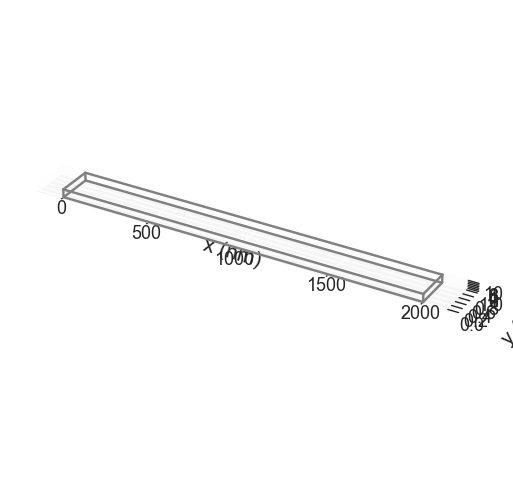

In [7]:
nx = 2000
mesh = df.Mesh(region=domain, n=[nx, 1, 1], bc=boundary_conditions)
mesh.mpl.subregions(figsize=(8, 6),multiplier=1e-9,box_aspect=(50, 5, 1), show_region=True)

In [8]:
# Properties required for plotting
system_prop = csp.SystemProperties(length=L_total, width=width, thickness=thickness)
system_prop.cell = (mesh.cell[0], mesh.cell[1], mesh.cell[2])
system_prop.units = ('m', 'm', 'm')
system_prop.update_numcells()

## 2. Define material regions along the chain.

In [9]:
# Suppose we have three materials:
#  - Left material: from x = 0 to L1
#  - Central material: from L1 to L2 (this one will have a DMI gradient)
#  - Right material: from L2 to L_total
L1 = 0.8e-6
L2 = 1.2e-6
system = mm.System(name="spin_chain")
system_region = csp.MyRegions(system.name + "_regions")

system_region.main(p1=system_prop.p1, p2=system_prop.p2, cellsize=system_prop.cell)

region_left = df.Region(
    pmin=[0, 0, 0],
    pmax=[L1, width, thickness],
    dims=['x','y','z'],
    units=['m','m','m']
)
region_center = df.Region(
    pmin=[L1, 0, 0],
    pmax=[L2, width, thickness],
    dims=['x','y','z'],
    units=['m','m','m']
)
region_right = df.Region(
    pmin=[L2, 0, 0],
    pmax=[L_total, width, thickness],
    dims=['x','y','z'],
    units=['m','m','m']
)

## 3. Subdivide the central region to define a DMI gradient.

In [10]:
D_chain = 0 # DMI constant (J/m^2)
D_min = 4e-4   # Minimum DMI constant (J/m^2)
D_max = 1.3e-3   # Maximum DMI constant (J/m^2)
n_subdivisions = 5
system = mm.System(name="spin_chain")

In [11]:
dmi_lhs_subregions = csp.MyRegions("dmi_lhs_subregions")
dmi_lhs_subregions.main(p1=tuple(region_center.pmin),
                        p2=(float(region_center.pmin[0] + 0.1e-6),
                            region_center.pmax[1],
                            region_center.pmax[2]))
dmi_lhs_subregions.main.dims = (n_subdivisions, 1, 1)
dmi_lhs_subregions.main.cell = (1.e-08, 1.e-09, 1.e-08)

dmi_lhs_mapping, dmi_lhs_subregions = csp.subdivide_region(dmi_lhs_subregions, dmi_lhs_subregions.main,
                                                           D_min, D_max,
                                                           compatible_discretisation=True,
                                                           subregion_name_root='dmi_lhs_grad',
                                                           n_subdivisions=n_subdivisions, axis='x')

In [12]:
dmi_center = {'dmi_center': D_max}

In [13]:
dmi_rhs_subregions = csp.MyRegions("dmi_rhs_subregions")
dmi_rhs_subregions.main(p1=(float(region_center.pmax[0] - 0.1e-6),
                            region_center.pmin[1],
                            region_center.pmin[2]),
                        p2=tuple(region_center.pmax))
dmi_rhs_subregions.main.dims = (n_subdivisions, 1, 1)
dmi_rhs_subregions.main.cell = (1.e-08, 1.e-09, 1.e-08)
dmi_rhs_mapping, dmi_rhs_subregions = csp.subdivide_region(dmi_rhs_subregions, dmi_rhs_subregions.main,
                                                           D_max, D_min,
                                                           compatible_discretisation=True,
                                                           subregion_name_root='dmi_rhs_grad',
                                                           n_subdivisions=n_subdivisions, axis='x')

In [14]:
dmi_merged_subregions = csp.merge_regions(dmi_lhs_subregions, dmi_rhs_subregions)

In [15]:
dmi_merged_mapping = csp.add_inter_subregion_values(dmi_lhs_mapping, dmi_center, dmi_rhs_mapping,
                                                    dmi_chain_left=D_chain,
                                                    dmi_chain_right=D_chain)

In [16]:
dmi_center_subregion = csp.SubRegion(name='dmi_center',
                                     p1=(float(region_center.pmin[0] + 0.1e-6), region_center.pmin[1], region_center.pmin[2]),
                                     p2=(float(region_center.pmax[0] - 0.1e-6), region_center.pmax[1], region_center.pmax[2])
                                     )
dmi_merged_subregions.add_subregion(dmi_center_subregion)

In [17]:
fixedLhs = csp.SubRegion(name='fixedLhs',
                         p1=system_prop.p1,
                         p2=(float(system_prop.p1[0] + system_prop.cell[0]),
                             system_prop.p2[1],
                             system_prop.p2[2])
                         )
# Append subregion to main container
fixedRhs = csp.SubRegion(name='fixedRhs',
                         p1=(float(system_prop.p2[0] - system_prop.cell[0]),
                             system_prop.p1[1],
                             system_prop.p1[2]),
                         p2=system_prop.p2
                         )
# Append subregion to main container

In [18]:
dmi_merged_subregions.add_subregion(fixedLhs)
dmi_merged_subregions.add_subregion(fixedRhs)

### Define a mapping from each subregion name to its DMI constant.

## 4. Build the system and assign regions.

# Create your system.

In [19]:
system = mm.System(name="spin_chain")

In [20]:
# Create the magnetisation field on the overall mesh.
def m_init_func(pos):
    if pos in region_left:
        return (0, 0, 1)
    if pos in region_right:
        return (0, 0, 1)
    return (0, 0, 1)

# Gyromagnetic ratio
gamma0 = 28.2e9 * 2 * np.pi

In [21]:
mesh = df.Mesh(region=domain, n=[nx, 1, 1], subregions=dmi_merged_subregions.subregions, bc=boundary_conditions)

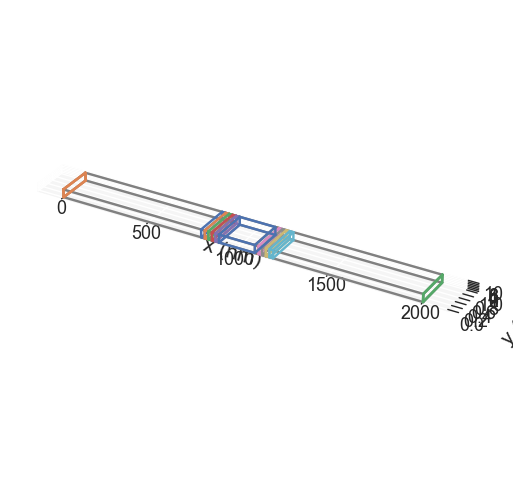

In [22]:
mesh.mpl.subregions(figsize=(8, 6),multiplier=1e-9,box_aspect=(50, 5, 1), show_region=True)

In [23]:
# Assume 'sat_mag' is defined elsewhere or pass your value directly.
sat_mag = 8e5
system.m = df.Field(mesh=mesh, nvdim=3, value=m_init_func, norm=sat_mag)

### Define energy terms.

In [24]:
# For example, exchange, Zeeman, DMI, and anisotropy.
# Note: For the DMI energy term, we pass the dmi_dict which maps subregion names to DMI values.
bias_field = tuple(x/mm.consts.mu0 for x in [0.0, 0.0, 1*0.15])  # A/m
system.energy = (mm.Exchange(A=1.3e-11)
                 + mm.Zeeman(H=bias_field, name='static')
                 + mm.DMI(D=dmi_merged_mapping, crystalclass='Cnv_y')
                 #mm.UniaxialAnisotropy(K1=0, K2=0, u=(0, 0, 1))
                 + mm.Demag()
)

In [25]:
alpha_bulk = 1e-3
alpha_drive = 1e-3

In [26]:
dmi_center_subregion

p1: (9e-07, 0.0, 0.0), p2: (1.1e-06, 1e-09, 1e-08), cell: (), dims: (), dim. labels: ('x', 'y', 'z'), units: ('m', 'm', 'm')

In [27]:
def alpha_func(pos):
    # Define the alpha value based on the position
    if pos in region_center:
        if pos in dmi_center_subregion.region:
            return alpha_drive

    return alpha_bulk  # Default value for other regions

In [28]:
alpha_field = df.Field(mesh=mesh, nvdim=1, value=alpha_func)

In [29]:
system.dynamics = mm.Precession(gamma0=gamma0*mm.consts.mu0) + mm.Damping(alpha=alpha_field)

### Now, use your custom system properties routines to define the regions.

In [30]:
####

## 5. Run the simulation (using your driver, etc.)

In [31]:
# Define parameters required by the numerical solver.
tmax = 1e-9  # Total simulation time in seconds
stepsize = 1e-12  # Step size in seconds
num_steps = int(tmax / stepsize) # Number of time steps
driving_freq = 18.00 *1e9

data_output = '/Users/cameronmceleney/Data/2025-04-03/Ubermag_data'
figs_output = '/Users/cameronmceleney/Data/2025-04-03/Ubermag_output'

### Define the Driver: here we use OOMMF's implementation of Runge-Kutta-Fehlberg (54).

In [32]:
min_evolver = oc.CGEvolver(method='Polak-Ribiere',
                           fixed_spins=['fixedLhs', 'fixedRhs']
                           )

minD = oc.MinDriver(evolver=min_evolver,
                    stopping_mxHxm=0.1)

minD.drive(system, dirname=data_output,
           fixed_subregions=['fixedLhs', 'fixedRhs'],
           verbose=2)

Running OOMMF (TclOOMMFRunner)[2025/04/17 13:55]... (1.2 s)


In [33]:
test_drive = df.Region(p1=(-10e-9, 0, 0), p2=(-5e-9, system_prop.p2[1], system_prop.p2[2]))

In [34]:
h0 = tuple(x/mm.consts.mu0 for x in [40e-3, 0.0, 0.0])  # A/m
# Define the smoothing function

def h0_func(pos):
    if pos in test_drive:
        return h0
    # No drive outside these regions
    return (0, 0, 0)

h0_field = df.Field(mesh=mesh, nvdim=3, value=h0_func)

In [35]:
system.energy += mm.Zeeman(H=h0_field, name='pump', func='sin',f=driving_freq, t0=0*stepsize)

In [36]:
sim_evolver = oc.RungeKuttaEvolver(method='rkf54',
                                   #alpha=alpha,
                                   #gamma_G=gamma0*mm.consts.mu0,
                                   fixed_spins=['fixedLhs', 'fixedRhs'],
                                   do_precess=1,
                                   allow_signed_gamma=0,
                                   )
td = oc.TimeDriver(evolver=sim_evolver)

In [37]:
# For example, assuming you have already set up your driver (td) and simulation parameters:
td.drive(system, dirname=data_output, t=tmax, n=num_steps,
         fixed_subregions=['fixedLhs', 'fixedRhs'],
         n_threads=11, verbose=2)

Running OOMMF (TclOOMMFRunner):   0%|          | 0/1000 files written [00:00]

Running OOMMF (TclOOMMFRunner)[2025/04/17 13:55] took 11.8 s


KeyboardInterrupt: 

## 6. Post-process the results.

In [ ]:

from custom_helper_files import custom_image_processing as cip

cip.default_three_pane(system, system_prop, system_region,
                       figs_output, system.drive_number - 1,
                       f'driven_{system.drive_number - 1}', has_schematic=False)

In [35]:
import discretisedfield as df
import micromagneticmodel as mm

# Create a main region and mesh.
# For this example we use a region with x in [0, 5], y and z fixed.
p1 = (0, 0, 0)
p2 = (5, 1, 1)
cell = (1, 1, 1)  # Use a 1×1×1 cell
main_region = df.Region(p1=p1, p2=p2)
mesh = df.Mesh(region=main_region, cell=cell)

# Define five equal-length subregions along the x-axis.
subregions = {}
for i in range(5):
    # Each subregion covers an interval [i, i+1] in x.
    subregions[f'sub{i+1}'] = df.Region(p1=(i, 0, 0), p2=(i+1, 1, 1))

# Create a damping field over the whole mesh with a default damping value.
default_damping = 0.01
damping_field = df.Field(mesh, nvdim=1, value=default_damping)

# Update damping in selected subregions.
# For example, let:
#   Subregion 1 get damping 0.02,
#   Subregion 3 get damping 0.005,
#   Subregion 5 get damping 0.03.
#
# Here we use the [] operator to extract the subfield.
# (If the subfield extraction produces a copy instead of a view, then
#  you should compute the indices corresponding to the subregion and update
#  the parent field’s data array directly.)
submesh_1 = damping_field[subregions['sub1']].mesh
submesh_2 = damping_field[subregions['sub2']].mesh

In [52]:
submesh_1.region

array([0., 0., 0.])

In [58]:
subregion_1 = submesh_1.region
subregion_2 = submesh_2.region

damping_subfield_1 = damping_field[subregion_1]
damping_subfield_2 = damping_field[subregion_2]

In [62]:
damping_subfield_1 = df.Field(mesh=submesh_1, nvdim=1, value=default_damping*3)
damping_subfield_2 = df.Field(mesh=submesh_2, nvdim=1, value=default_damping*2)

In [47]:
for val in damping_subfield_1:
    print(val)

[0.03]


In [48]:
merged_subfields = damping_subfield_1 + damping_subfield_2

ValueError: To perform this operation both fields must have the same mesh.

In [40]:
system = mm.System(name="example_system")
system.dynamics += mm.Damping(name='test1', alpha=damping_subfield_1)
system.dynamics += mm.Damping(name='test2', alpha=damping_subfield_2)
system.dynamics += mm.Damping(alpha=0.01)

In [42]:
system.dynamics.damping.name

'damping'

In [96]:
import discretisedfield as df
import numpy as np
import micromagneticmodel as mm

# Create a main region and mesh.
# For this example we use a region with x in [0, 5], y and z fixed.
p1 = (0, 0, 0)
p2 = (10, 1, 1)
cell = (1, 1, 1)  # Use a 1×1×1 cell
main_region = df.Region(p1=p1, p2=p2, units=('nm','nm','nm'))
mesh = df.Mesh(region=main_region, cell=cell)
submesh_1 = mesh[df.Region(p1=(0,0,0), p2=(5,1,1), units=('nm','nm','nm'))]
submesh_2 = mesh[df.Region(p1=(5,0,0), p2=(10,1,1), units=('nm','nm','nm'))]

In [97]:
field_1 = df.Field(mesh=mesh, nvdim=1, value=0.1)
field_2 = df.Field(mesh=submesh_1, nvdim=1, value=0.01)
field_3 = df.Field(mesh=submesh_2, nvdim=1, value=0.1)

In [98]:
system = mm.System(name="example_system")
system.m = df.Field(mesh=mesh, nvdim=3, value=(0, 0, 1), norm=1e6)
system.energy = mm.Zeeman(name='test_1', H=field_1) + mm.Zeeman(name='test_2', H=field_2)
system.dynamics = mm.Precession(gamma0=28.2e9 * 2 * np.pi) + mm.Damping(alpha=0.01)

In [99]:
td = oc.TimeDriver()
td.drive(system, dirname='/Users/cameronmceleney/Data/2025-04-16/Ubermag_data', verbose=2, t=1e-9, n=200)


Running OOMMF (TclOOMMFRunner):   0%|          | 0/200 files written [00:00]

Running OOMMF (TclOOMMFRunner)[2025/04/16 17:40] took 2.0 s


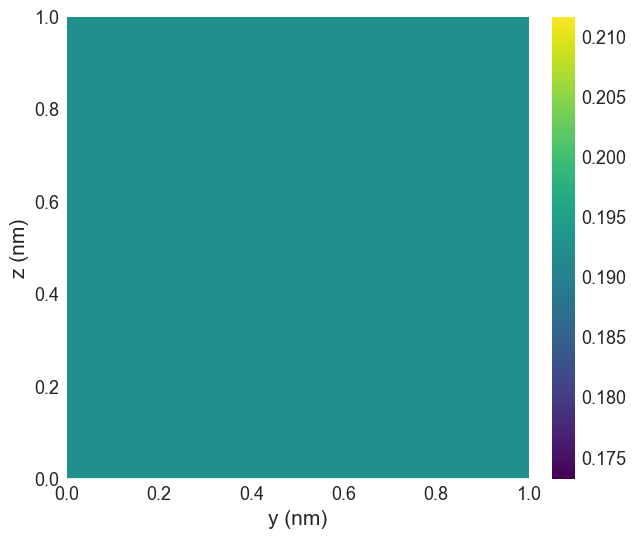

In [101]:
system.m.orientation.x.sel('x').mpl()

In [417]:
import oommfc as oc
import discretisedfield as df
import micromagneticmodel as mm
import numpy as np

lx = ly = 120e-9  # x and y dimensions of the sample(m)
lz = 10e-9  # sample thickness (m)
dx = dy = dz = 5e-9  # discretisation in x, y, and z directions (m)

Ms = 8e5  # saturation magnetisation (A/m)
A = 1.3e-11  # exchange energy constant (J/m)
H = 8e4 * np.array([0.81345856316858023, 0.58162287266553481, 0.0])
alpha = 0.008  # Gilbert damping
gamma0 = 2.211e5
mesh = df.Mesh(p1=(0, 0, 0), p2=(lx, ly, lz), cell=(dx, dy, dz))

system = mm.System(name="stdprobfmr")

submesh_1 = mesh[df.Region(p1=mesh.region.pmin, p2=(lx/2,ly,lz))]
submesh_2 = mesh[df.Region(p1=(lx/2,0,0), p2=mesh.region.pmax)]
subfield_1 = df.Field(mesh=submesh_1, nvdim=3, value=8e4 * np.array([0.81345856316858023, 0, 0.0]))
subfield_2 = df.Field(mesh=submesh_2, nvdim=3, value=8e4 * np.array([-0.81345856316858023, 0, 0.0]))

def m_init(pos):
    if pos in submesh_1.region:
        return (1, 0, 0)
    elif pos in submesh_2.region:
        return (-1, 0, 0)
system.energy = mm.Exchange(A=A) + mm.Demag() + mm.Zeeman(name='pump1', H=subfield_1) + mm.Zeeman(name='pump2', H=subfield_2)

system.energy += mm.DMI(
    crystalclass='Cnv_y',
    D=1.3e-3
)


system.dynamics = mm.Precession(gamma0=gamma0) + mm.Damping(alpha=alpha)
system.m = df.Field(mesh, nvdim=3, value=m_init, norm=Ms)

In [329]:
md = oc.MinDriver()
md.drive(system, dirname='/Users/cameronmceleney/Data/2025-04-16/Ubermag_data')

Running OOMMF (TclOOMMFRunner)[2025/04/16 18:55]... (0.6 s)


RuntimeError: Error in OOMMF run.
command: tclsh /Applications/oommf/oommf/oommf.tcl boxsi +fg stdprobfmr.mif -exitondone 1
stdout: [18:55:41] Start: "/Users/cameronmceleney/Data/2025-04-16/Ubermag_data/stdprobfmr/drive-27/stdprobfmr.mif"
Options: -exitondone 1 -threads 8
ERROR Reading MIF file: 
Error thrown from inside "Oxs_ExtCreateAndRegister" --- Incomplete or incorrect initialization --- Oxs_Ext initialization error in construction of Oxs_DMI_Cnv_y:dmi --- Oxs_Ext ERROR in object Oxs_DMI_Cnv_y:dmi: First entry in D[0] sub-list, "D_default", is not a known region in atlas "Oxs_BoxAtlas:main_atlas".  Second entry in D[0] sub-list, "D_default", is not a known region in atlas "Oxs_BoxAtlas:main_atlas".  Known regions: 
universe 
main
 See log file for additional details
*** Error loading /Users/cameronmceleney/Data/2025-04-16/Ubermag_data/stdprobfmr/drive-27/stdprobfmr.mif:
	
Error thrown from inside "Oxs_ExtCreateAndRegister" --- Incomplete or incorrect initialization --- Oxs_Ext initialization error in construction of Oxs_DMI_Cnv_y:dmi --- Oxs_Ext ERROR in object Oxs_DMI_Cnv_y:dmi: First entry in D[0] sub-list, "D_default", is not a known region in atlas "Oxs_BoxAtlas:main_atlas".  Second entry in D[0] sub-list, "D_default", is not a known region in atlas "Oxs_BoxAtlas:main_atlas".  Known regions: 
universe 
main
Error thrown from inside "Oxs_Director::ProbInit" --- Tcl error --- ERROR
   in file: /Applications/oommf/oommf/app/oxs/base/director.cc
   at line: 735

Error thrown from inside "Oxs_ExtCreateAndRegister" --- Incomplete or incorrect initialization --- Oxs_Ext initialization error in construction of Oxs_DMI_Cnv_y:dmi --- Oxs_Ext ERROR in object Oxs_DMI_Cnv_y:dmi: First entry in D[0] sub-list, "D_default", is not a known region in atlas "Oxs_BoxAtlas:main_atlas".  Second entry in D[0] sub-list, "D_default", is not a known region in atlas "Oxs_BoxAtlas:main_atlas".  Known regions: 
universe 
main
[18:55:41] Error loading /Users/cameronmceleney/Data/2025-04-16/Ubermag_data/stdprobfmr/drive-27/stdprobfmr.mif:
	
Error thrown from inside "Oxs_ExtCreateAndRegister" --- Incomplete or incorrect initialization --- Oxs_Ext initialization error in construction of Oxs_DMI_Cnv_y:dmi --- Oxs_Ext ERROR in object Oxs_DMI_Cnv_y:dmi: First entry in D[0] sub-list, "D_default", is not a known region in atlas "Oxs_BoxAtlas:main_atlas".  Second entry in D[0] sub-list, "D_default", is not a known region in atlas "Oxs_BoxAtlas:main_atlas".  Known regions: 
universe 
main
Error thrown from inside "Oxs_Director::ProbInit" --- Tcl error --- ERROR
   in file: /Applications/oommf/oommf/app/oxs/base/director.cc
   at line: 735

Error thrown from inside "Oxs_ExtCreateAndRegister" --- Incomplete or incorrect initialization --- Oxs_Ext initialization error in construction of Oxs_DMI_Cnv_y:dmi --- Oxs_Ext ERROR in object Oxs_DMI_Cnv_y:dmi: First entry in D[0] sub-list, "D_default", is not a known region in atlas "Oxs_BoxAtlas:main_atlas".  Second entry in D[0] sub-list, "D_default", is not a known region in atlas "Oxs_BoxAtlas:main_atlas".  Known regions: 
universe 
main
[18:55:41] Boxsi run end
[18:55:41] Error loading /Users/cameronmceleney/Data/2025-04-16/Ubermag_data/stdprobfmr/drive-27/stdprobfmr.mif:
	
Error thrown from inside "Oxs_ExtCreateAndRegister" --- Incomplete or incorrect initialization --- Oxs_Ext initialization error in construction of Oxs_DMI_Cnv_y:dmi --- Oxs_Ext ERROR in object Oxs_DMI_Cnv_y:dmi: First entry in D[0] sub-list, "D_default", is not a known region in atlas "Oxs_BoxAtlas:main_atlas".  Second entry in D[0] sub-list, "D_default", is not a known region in atlas "Oxs_BoxAtlas:main_atlas".  Known regions: 
universe 
main
Error thrown from inside "Oxs_Director::ProbInit" --- Tcl error --- ERROR
   in file: /Applications/oommf/oommf/app/oxs/base/director.cc
   at line: 735

Error thrown from inside "Oxs_ExtCreateAndRegister" --- Incomplete or incorrect initialization --- Oxs_Ext initialization error in construction of Oxs_DMI_Cnv_y:dmi --- Oxs_Ext ERROR in object Oxs_DMI_Cnv_y:dmi: First entry in D[0] sub-list, "D_default", is not a known region in atlas "Oxs_BoxAtlas:main_atlas".  Second entry in D[0] sub-list, "D_default", is not a known region in atlas "Oxs_BoxAtlas:main_atlas".  Known regions: 
universe 
main

stderr: 


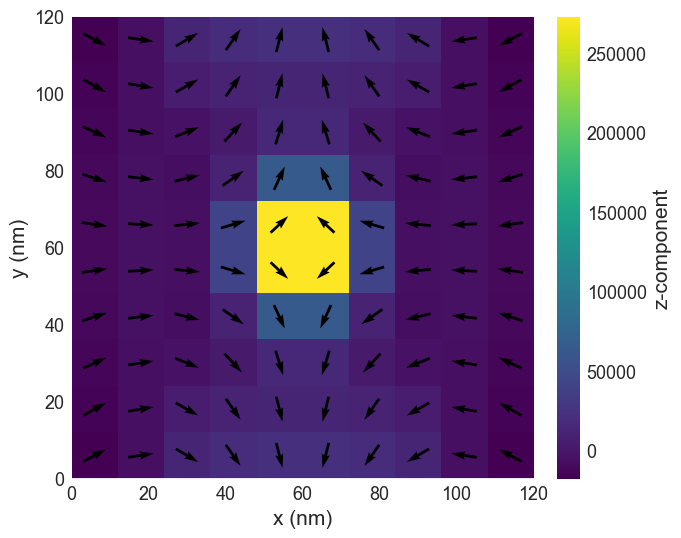

In [182]:
system.m.sel("z").resample((10, 10)).mpl()

In [266]:
submesh_1.region

Region(pmin=[0.0, 0.0, 0.0], pmax=[6e-08, 1.2e-07, 1e-08], dims=['x', 'y', 'z'], units=['m', 'm', 'm'])

In [183]:
# Change external magnetic field.
H = 8e4 * np.array([-0.81345856316858023, 0, 0.0])
system.energy.pump1.H = H

T = 20e-9
n = 200

td = oc.TimeDriver()
td.drive(system, dirname='/Users/cameronmceleney/Data/2025-04-16/Ubermag_data', verbose=2, t=20e-9, n=200)

Running OOMMF (TclOOMMFRunner):   0%|          | 0/200 files written [00:00]

Running OOMMF (TclOOMMFRunner)[2025/04/16 18:13] took 27.3 s


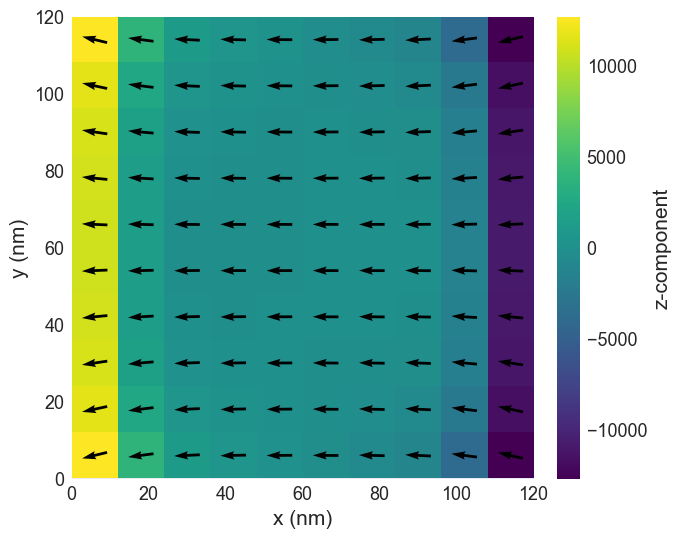

In [184]:
system.m.sel("z").resample((10, 10)).mpl()

In [ ]:
system.energy += mm.DMI(
    crystalclass='Cnv_y',
    D=df.Field()
)

In [315]:
lx = 120e-9
ly = 120e-9
lz = 10e-9
dx = dy = dz = 5e-9

In [316]:
region = df.Region(p1=(0, 0, 0), p2=(lx, ly, lz), units=('m', 'm', 'm'))
mesh = df.Mesh(region=region, cell=(dx, dy, dz))

In [317]:
mesh

Mesh(Region(pmin=[0.0, 0.0, 0.0], pmax=[1.2e-07, 1.2e-07, 1e-08], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), n=[24, 24, 2])

In [293]:
mesh2: df.Mesh = mesh[df.Region(p1=(0,0,0), p2=(lx/2,ly/2,lz))]

In [258]:
mesh2.scale(factor=(2,1,1), reference_point=mesh2.region.pmin, inplace=True)
mesh2 = df.Mesh(region=mesh2.region, cell=mesh.cell)

In [227]:
mesh.scale(factor=(2,1,1), inplace=True)

Mesh(Region(pmin=[-6e-08, 0.0, 0.0], pmax=[1.7999999999999997e-07, 1.2e-07, 1e-08], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), n=[24, 24, 2])

In [215]:
pmin = [-6e-08, 0.0, 0.0]
pmax = [1.7999999999999997e-07, 1.2e-07, 1e-08]
dims = ['x', 'y', 'z']
units = ['m', 'm', 'm']
n = [24, 24, 2]

cells(x=array([5.00e-09, 1.50e-08, 2.50e-08, 3.50e-08, 4.50e-08, 5.50e-08,
       6.50e-08, 7.50e-08, 8.50e-08, 9.50e-08, 1.05e-07, 1.15e-07,
       1.25e-07, 1.35e-07, 1.45e-07, 1.55e-07, 1.65e-07, 1.75e-07,
       1.85e-07, 1.95e-07, 2.05e-07, 2.15e-07, 2.25e-07, 2.35e-07]), y=array([2.500e-09, 7.500e-09, 1.250e-08, 1.750e-08, 2.250e-08, 2.750e-08,
       3.250e-08, 3.750e-08, 4.250e-08, 4.750e-08, 5.250e-08, 5.750e-08,
       6.250e-08, 6.750e-08, 7.250e-08, 7.750e-08, 8.250e-08, 8.750e-08,
       9.250e-08, 9.750e-08, 1.025e-07, 1.075e-07, 1.125e-07, 1.175e-07]), z=array([2.5e-09, 7.5e-09]))

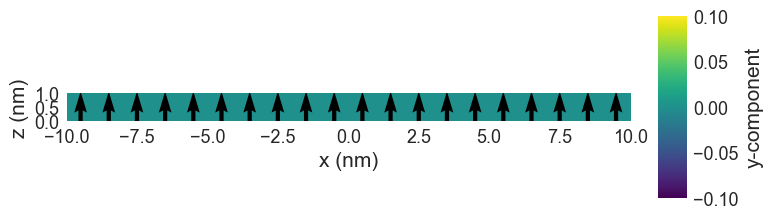

In [404]:
import discretisedfield as df
import micromagneticmodel as mm

import oommfc as oc

p1 = (-10e-9, 0, 0)
p2 = (10e-9, 1e-9, 1e-9)
cell = (1e-9, 1e-9, 1e-9)
subregions = {
    "region1": df.Region(p1=(-10e-9, 0, 0), p2=(0, 1e-9, 1e-9)),
    "region2": df.Region(p1=(0, 0, 0), p2=(10e-9, 1e-9, 1e-9)),
}
region = df.Region(p1=p1, p2=p2)
mesh = df.Mesh(region=region, cell=cell, subregions=subregions)

D = {"region1": 0e-3, "region2": 1e-3, }#"region2:region1": -1.5e-3, "region1:region2": 0}

Ms = 8e5  # saturation magnetisation (A/m)


def m_fun(pos):
    """Return random 3d vectors for initial random magnetisation"""
    #return [2 * random.random() - 1, 2 * random.random() - 1, 2 * random.random() - 1]
    return (0,0,1)

system = mm.System(name="dmi_dict_D")
system.energy = mm.DMI(D=D, crystalclass="Cnv_z") + mm.Zeeman(H=(0, 0, 0.1/1.256e-6))
system.m = df.Field(mesh, nvdim=3, value=m_fun, norm=Ms)
#system.m.k3d.vector(color_field=system.m.z)
system.m.sel("y").mpl()

In [405]:
md = oc.MinDriver()
md.drive(system, dirname='/Users/cameronmceleney/Data/2025-04-16/Ubermag_data')

Running OOMMF (TclOOMMFRunner)[2025/04/16 20:33]... (0.6 s)


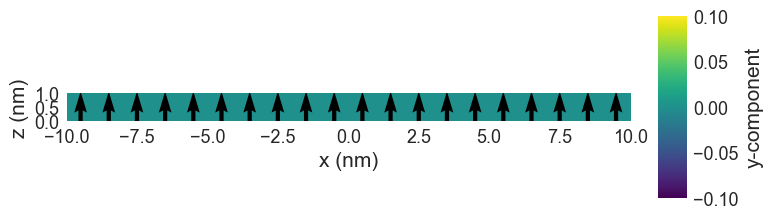

In [406]:
#system.m.k3d.vector(color_field=system.m.z)
system.m.sel("y").mpl()

In [407]:
test_region = df.Region(p1=(0, 0, 0), p2=(10e-9, 1e-9, 1e-9))

In [408]:
test_region2 = test_region.scale(factor=(2, 1, 1), reference_point=test_region.pmin)

In [416]:
test_region.pmin

array([0., 0., 0.])

In [56]:
lx = ly = 120e-9  # x and y dimensions of the sample(m)
lz = 10e-9  # sample thickness (m)
dx = dy = dz = 5e-9  # discretisation in x, y, and z directions (m)

Ms = 8e5  # saturation magnetisation (A/m)

domain = df.Region(p1=(0, 0, 0), p2=(lx, ly, lz))# cell size in x, y, and z directions (m)
mesh = df.Mesh(domain, cell=(dx, dy, dz))

# Define a submesh for the damping
subregion_1: df.Region = df.Region(p1=(0,0,0),
                                   p2=(lx/4,ly,lz))

# Use translate to highlight how this could be made dynamic. Intentionally not manually defining regions
subregion_2: df.Region = subregion_1.translate(vector=(lx/4,0,0),
                                    inplace=False)

# Create a new submesh that is insulated from the main mesh
damping_mesh: df.Mesh = df.Mesh(region=domain,  # use Domain to show both meshes explicitly use the same region
                                cell=mesh.cell,  # Use mesh.cell to show the coupling between the two meshes
                                subregions=[subregion_1, subregion_2]
                                )

# Check that the two meshes are aligned
if not mesh.is_aligned(damping_mesh):
    raise ValueError("damping_mesh not aligned with the main mesh")

# Define custom functions. Created two different subfields to show how they can later be combined
def first_subfield_func(pos):
    # Returns a value for the spatially-dependent damping factor
    if pos in subregion_1:
        return 1e-2
    else:
        return 0.0

def second_subfield_func(pos):
    # Returns a value for the spatially-dependent damping factor
    if pos in subregion_2:
        return 1e-3
    else:
        return 0.0

def bg_alpha(pos):
    return 1e-1

# Create the subfields using the custom functions
subfield_1 = df.Field(mesh=damping_mesh, nvdim=1, value=first_subfield_func)
subfield_2 = df.Field(mesh=damping_mesh, nvdim=1, value=second_subfield_func)
bg_field = df.Field(mesh=damping_mesh, nvdim=1, value=bg_alpha)
# As both subfields were defined on the same mesh, they can be combined.

# Intentionally do not use sum()
overall_subfield = (bg_field
                    + (subfield_1 - bg_field)
                    + (subfield_2 - bg_field)
                    )

# Result is a single field over the entire submesh.
system.dynamics = mm.Damping(alpha=overall_subfield)

# Now go on to define:
# system.m = ...
# system.energy = ...
# system.dynamics += mm.Precession(...)

TypeError: Subregions must be a dictionary relating the name of a subregion with its region.

In [54]:
##system.dynamics.damping.alpha

True

In [5]:
import ipywidgets as widgets
from IPython.display import display
output = widgets.Output()

@output.capture(clear_output=True,wait=True) # based on https://github.com/jupyter-widgets/ipywidgets/issues/1846 and https://ipywidgets.readthedocs.io/en/latest/examples/Output%20Widget.html
def say_hello(message: str = "You have pushed the button, congratulations I guess"):
    print(message)

run_button = widgets.Button(
      description = 'continue'
)
print("Hello, please push the continue button")
run_button.on_click(say_hello)
display(run_button)
output

Hello, please push the continue button


Button(description='continue', style=ButtonStyle())

Output()

In [16]:
%matplotlib

Using matplotlib backend: module://matplotlib_inline.backend_inline
